### Imports

In [62]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import SGDRegressor

from sklearn.pipeline import Pipeline

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV

from ml_utils import edaDF
import toolbox as tb

plt.rcParams["figure.figsize"] = (6, 4)

In [63]:
# Download and load the data
import keras
import os

f_path_1 = "data/Euro_Salary.csv"
url_1 = "https://github.com/AkeemSemper/ml_data/raw/main/Euro_Salary.csv"
if not os.path.exists(f_path_1):
    file_1 = keras.utils.get_file(f_path_1, url_1)
    
df = pd.read_csv(f_path_1)

### Reload & Display Options

In [64]:
# Reload utility files

import importlib
importlib.reload(tb)

#from ml_eda import edaDF

<module 'toolbox' from 'c:\\Users\\msieb\\OneDrive\\Documents\\1 NAIT\\1 - DATA3950 MACHINE LEARNING\\Repository\\3950-assignment-2-mlsiebold\\toolbox.py'>

In [65]:
# Display options

# Display all columns
pd.set_option('display.max_columns', None)

# Display all rows
#pd.set_option('display.max_rows', None)

# Dispay all output
#pd.set_option('display.max_seq_items', None)            # Not sure this works 

# Change display format for float values (comma seperators, 2 decimals)
pd.options.display.float_format = '{:,.2f}'.format

# Set default figsize for workbook
plt.rcParams["figure.figsize"] = (8,8)

# Assignment 2 - Regression
### Predict the TOTAL COMPENSATION for this year. 

The data file provided is a salary survey for tech workers in Europe. We want to predict the total amount of compensation they bring in each year, based off of the details of their work. 

Some notes that will be important:
<ul>
    <li>The total compensation will need to be constructed, there is a column for salary, "Yearly brutto salary (without bonus and stocks) in EUR", as well as a column for bonus compensation, "Yearly bonus + stocks in EUR". 
    <li>Some categorical variables will need some work, and there isn't generally an exact answer. The main concern is things with categories that have a bunch of values with a very small count. For example, if there is only 1 person in City X, then that value likely needs to be addressed. We don't want it encoded into a new column of one 1 and thousands of 0s. 
    <li>There is an article exploring some of the data here: https://www.asdcode.de/2021/01/it-salary-survey-december-2020.html
    <li>Imputation and a bit of data manipulation will be required. 
    <li>Use any regression method you'd like. Some ones are closely related to what we've done, you may want to look at them, e.g. ExtraTreesRegressor. 
    <li>Initial accurracy, and potentially final accuracy, may not be great. When I made a plain model will little optimization the errors were large and the R2 was low. There is lots of room for optimization. 
    <li>Research challenge - try some work on the target, look into TransformedTargetRegressor and see if that helps. Recall in stats when we had skewed distributions... Maybe it helps, maybe it doesn't. 
    <li>EDA and data prep are up to you - you'll probably need to do a little exploring to figure out what cleanup is needed. When I did it, I did things kind of iteratively when I did it. For example, look at the value counts, figure out how to treat the different categories, clean something up, look at the results, potentially repeat if needed. After you figure out what needs to be done, you may be able to take some of those steps and incorporate them into a pipeline to be cleaner....
    <li><b>CRITICAL - Please make sure you publish it after having run it, all the output should be showing.</b>
</ul>

### Details and Deliverables

You'll need to build code to produce the predictions. In particular, there's a few things that'll be marked:
<ul>
    <li>Please add a "presentation version" at the bottom, where you show what you did, and the results. Basically, you start with the original data, you do some work to figure out what's needed, you try a few models and select the best. At the bottom, put what <i>you actually settled on</i>, i.e. after all the figuring and exploring, here's the code that goes from raw data to final results, and here's what the results were. I should be able to read this part and understand what you did clearly:
    <ul>
        <li> Please make a pipeline that does the prep work - you may need some exploration or several trials before settling on what exactly to use, that's normal. Once you've settled, build that into a pipeline so it's clear and repeatable.
        <li> What you settled on for data cleaning, along with what prompted it. 
        <li> Feature Selection - Please identify what you did for feature selection. No need for a long explaination, something along the lines of "I did X, and the result was that 4 features were removed". Try at least 2 things. 
        <li> Model selection - between selecting a model style and tuning it with hyperparameters, what did you test and what won?
        <li> Overall, how good was your model and what things may make sense to try to do even better? 
        <li> If you could use titles/bullet points I'd really appreciate it. 
    </ul>
    <li>Grade Breakdown:
    <ul>
        <li> Code is readable, there are comments: 20%
        <li> Explaination as defined above: 60% (20% each point)
        <li> Accuracy: 20% As compared to everyone else. This will be generously graded, I won't be surprised if overall accuracy is low for most people. 
    </ul>
</ul>

<b>The biggest challenge here is translating the data into something useful and clean. This will probably require a bit of exploration, examining the data, thinking about what it means, trying something, then making a model to see what the results are. In particular, think about what value some of the less clean bits of data my hold - binning/grouping, numerical transformations, outlier removal, etc... are all likely to be useful somewhere. You almost certainly need to look at it column by column and make a decision, I'll apologize up front, it isn't the most fun process in the world. There is not one specific correct answer.</b>

### Basic Cleaning

In [66]:
#  Remove whitespaces and weird characters

import unicodedata

df = df.apply(lambda col: col.map(tb.clean_string))     # Clean entire df
df.columns = df.columns.map(tb.clean_string)            # Clean column headers

In [67]:
# Replace null-like values with NaN

tb.clean_null_like(df, columns=None)

### Data Dictionary

In [68]:
# Create data dictionary

data_dict = pd.DataFrame({
    'Dtype': df.dtypes,
    'Semantic Type': None,
    'Desc': None,
    '# of Nulls': df.isna().sum(),
    '# of Unique Values': df.nunique()
    })                                      #.reset_index(names='Column')

data_dict.index.name = 'Column'             # Give the index a name

In [69]:
# Create description dictionary scaffold to add manually input column descriptions to data dictionary

# Create list of columns
cols = df.columns.to_list()

# Scaffold for descriptions
desc_dict = {col: '' for col in cols}
#desc_dict

# Scaffold for semantics (numeric, categorical)
semantic_dict = {col: '' for col in cols}
#semantic_dict

In [70]:
# Manually update description dictionary

desc_dict = {
 'timestamp': 'Date and time survey response was submitted (acts as survey submission identifier)',
 'age': "Respondent's age in years",
 'gender': "Respondent's self-report gender",
 'city': 'City in which the respondent works (primarily German cities, with a few internationaly cities)',
 'position': 'Current job title or primary role',
 'total years of experience': 'Total number of years the respondent has worked in their profession',
 'years of experience in germany': 'Number of years the respondent has worked specifically in Germany',
 'seniority level': 'Self‑reported seniority',
 'your main technology / programming language': 'Primary programming language or technology used in the respondent’s job',
 'other technologies/programming languages you use often': 'Additional languages, frameworks, or tools the respondent frequently uses',
 'yearly brutto salary (without bonus and stocks) in eur': 'Annual gross base salary in euros, excluding bonuses and stock compensation',
 'yearly bonus + stocks in eur': 'Annual bonus and/or stock compensation in euros',
 'number of vacation days': 'Number of paid vacation days per year',
 'employment status': 'Type of employment',
 'contract duration': 'Type of employment contract',
 'main language at work': 'Primary language used in the workplace',
 'company size': 'Approximate number of employees in the respondent’s company',
 'company type': 'Type of organization respondent is employed for'}

In [71]:
# Manually update semantic type dictionary

semantic_dict = {
 'timestamp': 'categorical nominal',
 'age': 'numeric discrete',
 'gender': 'categorical nominal',
 'city': 'categorical nominal',
 'position': 'categorical nominal',
 'total years of experience': 'numeric continuous',
 'years of experience in germany': 'numeric continuous',
 'seniority level': 'categorical ordinal',
 'your main technology / programming language': 'categorical nominal',
 'other technologies/programming languages you use often': 'categorical nominal',
 'yearly brutto salary (without bonus and stocks) in eur': 'numeric continuous',
 'yearly bonus + stocks in eur': 'numeric continuous',
 'number of vacation days': 'numeric discrete',
 'employment status': 'categorical nominal',
 'contract duration': 'categorical nominal',
 'main language at work': 'categorical nominal',
 'company size': 'categorical ordinal',
 'company type': 'categorical nominal'}

In [72]:
# Map descriptions and semantics to data dictionary 

#data_dict['Desc'] = data_dict['Column'].map(desc_dict)
#data_dict['Semantic Type'] = data_dict['Column'].map(semantic_dict)

data_dict['Desc'] = data_dict.index.map(desc_dict)
data_dict['Semantic Type'] = data_dict.index.map(semantic_dict)

In [73]:
# Check my handywork

data_dict

,Dtype,Semantic Type,Desc,# of Nulls,# of Unique Values
Column,,,,,
timestamp,string[python],categorical nominal,Date and time survey response was submitted (a...,0,1248
age,float64,numeric discrete,Respondent's age in years,27,40
gender,string[python],categorical nominal,Respondent's self-report gender,10,3
city,string[python],categorical nominal,City in which the respondent works (primarily ...,0,106
position,string[python],categorical nominal,Current job title or primary role,6,133
total years of experience,string[python],numeric continuous,Total number of years the respondent has worke...,16,48
years of experience in germany,string[python],numeric continuous,Number of years the respondent has worked spec...,32,52
seniority level,string[python],categorical ordinal,Self‑reported seniority,12,21
your main technology / programming language,string[python],categorical nominal,Primary programming language or technology use...,128,206


In [74]:
# Save data dictionary to markdown file

data_dict.reset_index().to_csv('data_dictionary.tsv', sep='\t', index=False, encoding='utf-8-sig')

### Convert Dtypes

In [75]:
# Change dtypes based on semantic type

df = tb.apply_semantic_dtypes(df, data_dict, tb.semantic_to_dtype)

In [76]:
df.dtypes

Column
timestamp                                                 category
age                                                        float64
gender                                                    category
city                                                      category
position                                                  category
total years of experience                                  float64
years of experience in germany                             float64
seniority level                                           category
your main technology / programming language               category
other technologies/programming languages you use often    category
yearly brutto salary (without bonus and stocks) in eur     float64
yearly bonus + stocks in eur                               float64
number of vacation days                                    float64
employment status                                         category
contract duration                                      

### Basic EDA

In [77]:
# Total records

len(df)

1253

In [78]:
# Check for duplicates

df.duplicated().value_counts()

False    1253
Name: count, dtype: int64

In [79]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1253 entries, 0 to 1252
Data columns (total 18 columns):
 #   Column                                                  Non-Null Count  Dtype   
---  ------                                                  --------------  -----   
 0   timestamp                                               1253 non-null   category
 1   age                                                     1226 non-null   float64 
 2   gender                                                  1243 non-null   category
 3   city                                                    1253 non-null   category
 4   position                                                1247 non-null   category
 5   total years of experience                               1230 non-null   float64 
 6   years of experience in germany                          1195 non-null   float64 
 7   seniority level                                         1241 non-null   category
 8   your main technology / progr

In [80]:
# Basic stats

df.describe(include="all").T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
Column,,,,,,,,,,,
timestamp,1253,1248,24/11/2020 15:07:35,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,"1,226.00",NaN,NaN,NaN,32.51,5.66,20.00,29.00,32.00,35.00,69.00
gender,1243,3,male,1049,NaN,NaN,NaN,NaN,NaN,NaN,NaN
city,1253,106,berlin,681,NaN,NaN,NaN,NaN,NaN,NaN,NaN
position,1247,133,software engineer,387,NaN,NaN,NaN,NaN,NaN,NaN,NaN
total years of experience,"1,230.00",NaN,NaN,NaN,9.08,11.90,0.00,5.00,8.00,12.00,383.00
years of experience in germany,"1,195.00",NaN,NaN,NaN,3.75,3.66,0.00,1.00,3.00,5.00,30.00
seniority level,1241,21,senior,565,NaN,NaN,NaN,NaN,NaN,NaN,NaN
your main technology / programming language,1125,206,python,212,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [81]:
# Number of unique values per feature

print('\033[1m# of unique values:\033[0m')
print(df.nunique())

# of unique values:
Column
timestamp                                                 1248
age                                                         40
gender                                                       3
city                                                       106
position                                                   133
total years of experience                                   42
years of experience in germany                              36
seniority level                                             21
your main technology / programming language                206
other technologies/programming languages you use often     561
yearly brutto salary (without bonus and stocks) in eur     201
yearly bonus + stocks in eur                               162
number of vacation days                                     36
employment status                                           10
contract duration                                            3
main language at work       

### Column Specific EDA

In [82]:
# Set column lists

num_cols = tb.detect_num_cols(df)
cat_cols = tb.detect_cat_cols(df)

### **'Timestamp'**
- **Inconsistencies:**
    - no value added
- **Actions taken:**
    - drop column

In [83]:
# Basic EDA

column = 'timestamp'
tb.eda_column_summary(df, column)

=== COLUMN: timestamp ===

DTYPE:
category

NON-NULL VALUES:
1,253

NULL VALUES:
0

UNIQUE VALUES:
1,248

BASIC STATS:
count                    1253
unique                   1248
top       24/11/2020 15:07:35
freq                        2
Name: timestamp, dtype: object

TOP VALUES:
timestamp
24/11/2020 15:07:35    2
24/11/2020 13:55:19    2
24/11/2020 14:07:23    2
25/11/2020 08:47:37    2
25/11/2020 18:28:01    2
Name: count, dtype: int64

BOTTOM VALUES:
timestamp
30/11/2020 19:28:15    1
30/11/2020 20:09:04    1
30/11/2020 20:14:04    1
30/11/2020 20:39:33    1
30/11/2020 20:56:33    1
Name: count, dtype: int64


In [84]:
# Check if any duplicate timestamps might be duplicate records

df[df[column].duplicated(keep=False)].sort_values(by=column)

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type
234,24/11/2020 13:55:19,25.00,male,munich,ml engineer,1.00,1.00,middle,python,"python, c/c++, swift, matlab","65,000.00","2,000.00",30.00,full-time employee,unlimited contract,english,1000+,product
235,24/11/2020 13:55:19,32.00,male,berlin,engineering manager,9.00,5.00,lead,<NA>,"php, javascript / typescript, .net, sql, googl...","95,000.00","140,000.00",365.00,full-time employee,unlimited contract,english,1000+,product
246,24/11/2020 14:07:23,34.00,male,berlin,software engineer,14.00,5.00,senior,c#,"javascript / typescript, .net, sql, aws, docker","72,000.00",NaN,26.00,full-time employee,unlimited contract,english,101-1000,product
247,24/11/2020 14:07:23,37.00,male,berlin,team lead,12.00,10.00,head,python,"python, php, javascript / typescript, sql, docker","90,000.00",NaN,30.00,full-time employee,unlimited contract,english,11-50,consulting / agency
280,24/11/2020 15:07:35,33.00,male,frankfurt,software engineer,10.00,1.00,senior,.net,"javascript / typescript, sql, azure","26,400.00",NaN,NaN,self-employed (freelancer),unlimited contract,english,up to 10,startup
281,24/11/2020 15:07:35,28.00,male,berlin,frontend developer,8.00,5.00,senior,javascript,<NA>,"68,000.00",NaN,NaN,full-time employee,<NA>,<NA>,<NA>,<NA>
490,25/11/2020 08:47:37,29.00,male,munich,software engineer,8.00,6.00,middle,php,"javascript / typescript, sql","75,000.00",NaN,30.00,full-time employee,unlimited contract,english,1000+,product
491,25/11/2020 08:47:37,37.00,male,malta,software architect,18.00,NaN,head,go,"google cloud, kubernetes, docker, shell","156,000.00",0.00,0.00,self-employed (freelancer),unlimited contract,english,11-50,startup
665,25/11/2020 18:28:01,32.00,male,berlin,qa engineer,10.00,3.00,senior,js,"java / scala, google cloud, docker","81,000.00","45,000.00",30.00,full-time employee,unlimited contract,english,1000+,product
666,25/11/2020 18:28:01,32.00,male,cologne,devops,7.00,2.00,middle,k8s,"python, google cloud, kubernetes, docker","60,000.00",NaN,30.00,full-time employee,unlimited contract,english,101-1000,product


In [85]:
# Convert Timestamp to datetime 

df[column] = pd.to_datetime(df[column], errors='coerce')

C:\Users\msieb\AppData\Local\Temp\ipykernel_18476\1719035686.py:3: UserWarning: Parsing dates in %d/%m/%Y %H:%M:%S format when dayfirst=False (the default) was specified. Pass `dayfirst=True` or specify a format to silence this warning.
  df[column] = pd.to_datetime(df[column], errors='coerce')


In [86]:
# Look at date ranges

print(f'Oldest date: {df[column].min()}')
print(f'Most recent date: {df[column].max()}')

Oldest date: 2020-11-24 11:14:15
Most recent date: 2021-01-19 12:01:11


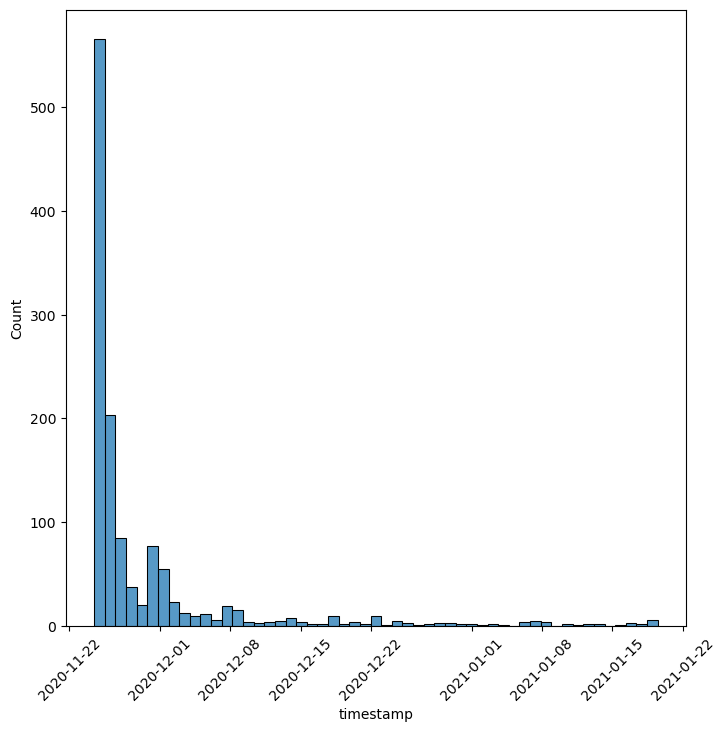

In [87]:
# Check distribution for funzies

sns.histplot(df, x=column)
plt.xticks(rotation=45);

##### **Observations**
- Duplicate Timestamp's look fine. No duplicate records
- Can't see any use for this column so drop it

### **'Age'**
- **Inconsistencies:**
    - null values
    - positive skew 
    - spike in distribution (age=30)
- **Actions taken:**
    - impute null values
    - standardize column (StandardScaler) or bin ages?
    - log transformation

In [88]:
# Basic EDA

column = 'age'
tb.eda_column_summary(df, column)

=== COLUMN: age ===

DTYPE:
float64

NON-NULL VALUES:
1,226

NULL VALUES:
27

UNIQUE VALUES:
40

BASIC STATS:
count   1,226.00
mean       32.51
std         5.66
min        20.00
25%        29.00
50%        32.00
75%        35.00
max        69.00
Name: age, dtype: float64

TOP VALUES:
age
30.00    110
32.00     94
33.00     94
28.00     87
31.00     87
Name: count, dtype: int64

BOTTOM VALUES:
age
50.00    1
21.00    1
20.00    1
69.00    1
52.00    1
Name: count, dtype: int64


In [89]:
# Look at age ranges

print(f'Youngest: {df[column].min()}')
print(f'Oldest: {df[column].max()}')


Youngest: 20.0
Oldest: 69.0


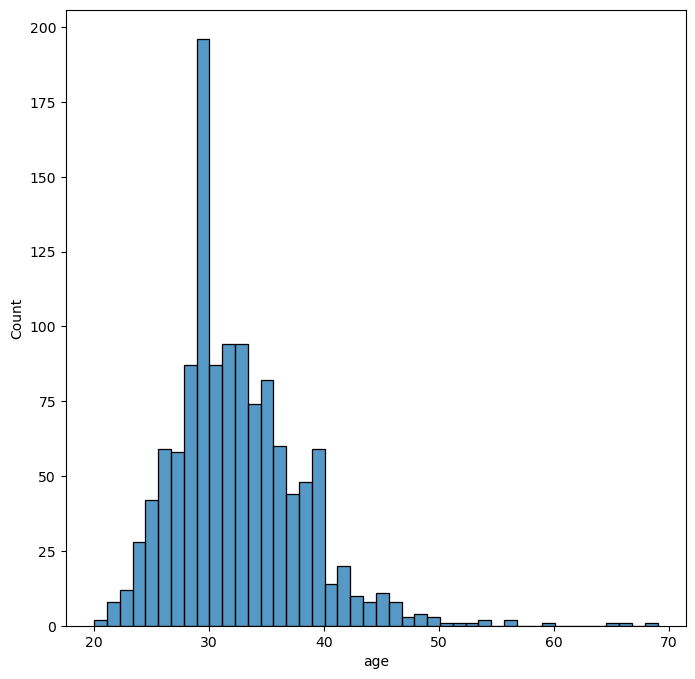

In [90]:
# Check distribution

sns.histplot(df, x=column);

In [91]:
# I wonder what that spike is...

df[column].value_counts().head(1)

age
30.00    110
Name: count, dtype: int64

In [92]:
# Check null records

df[df[column].isna()]

Column,timestamp,age,gender,city,position,total years of experience,years of experience in germany,seniority level,your main technology / programming language,other technologies/programming languages you use often,yearly brutto salary (without bonus and stocks) in eur,yearly bonus + stocks in eur,number of vacation days,employment status,contract duration,main language at work,company size,company type
11,2020-11-24 11:18:16,NaN,male,berlin,software engineer,25.00,11.00,senior,c++,"python, c/c++, sql","100,000.00",101.00,24.00,self-employed (freelancer),temporary contract,english,11-50,product
12,2020-11-24 11:18:22,NaN,<NA>,berlin,software engineer,NaN,NaN,lead,php,<NA>,"90,000.00","40,000.00",NaN,full-time employee,unlimited contract,english,1000+,<NA>
28,2020-11-24 11:25:35,NaN,male,berlin,devops,14.00,5.00,senior,<NA>,"python, go, aws, kubernetes, docker","67,000.00","7,000.00",30.00,full-time employee,unlimited contract,english,101-1000,product
55,2020-11-24 11:33:08,NaN,male,berlin,software engineer,NaN,1.00,senior,php,<NA>,"75,000.00",NaN,NaN,full-time employee,<NA>,english,<NA>,<NA>
113,2020-11-24 11:56:25,NaN,male,berlin,qa engineer,6.00,6.00,middle,javascript,"javascript / typescript, aws","50,000.00",NaN,30.00,full-time employee,unlimited contract,english,101-1000,product
300,2020-11-24 15:47:19,NaN,male,berlin,data engineer,7.50,1.50,middle,sql,"python, sql, aws, kubernetes, docker","68,000.00",500.00,30.00,full-time employee,unlimited contract,english,101-1000,product
330,2020-11-24 17:29:51,NaN,<NA>,munich,data scientist,2.00,2.00,middle,python,<NA>,"54,000.00",NaN,20.00,full-time employee,unlimited contract,english,51-100,product
340,2020-11-24 17:40:38,NaN,male,hamburg,support engineer,NaN,2.00,senior,<NA>,"kubernetes, docker","61,000.00",NaN,28.00,full-time employee,unlimited contract,english,<NA>,<NA>
365,2020-11-24 18:31:25,NaN,male,berlin,software engineer,9.00,1.00,lead,java,"aws, docker","75,000.00",NaN,24.00,full-time employee,unlimited contract,english,1000+,startup
374,2020-11-24 18:48:30,NaN,male,karlsruhe,backend developer,8.00,8.00,lead,python,"python, c/c++, javascript / typescript, java /...","65,000.00","5,400.00",29.00,part-time employee,unlimited contract,english,up to 10,product


In [93]:
# Wonder what's up with the records with a lot of null values

df.loc[[1180, 1181, 1231], 'yearly brutto salary (without bonus and stocks) in eur']

1180    30,000.00
1181   111,111.00
1231    70,000.00
Name: yearly brutto salary (without bonus and stocks) in eur, dtype: float64

##### **Observations**
- age range looks good
- positive skew
    - log transformation
- big spike at age 30 (maybe people rounded their age?)
    - try: 
        - standardizing this column (StandardScaler)
        - binning the ages
- don't think I want to drop outliers
- most records with null values in Age feild look ok
    - impute
- 3 records with mostly null values
    - 1180  & 1231 - fields with values look ok
        - impute
    - 1181 - salary looks sus
        - consider dropping record (too little info to be valuable)
        - deal with it in Salary section

### **'Gender'**
- **Inconsistencies:**
    - null values
    - 'Diverse' gender has too few values for a predictive model to learn from
        - ethical considerations
- **Actions taken:**
    - drop column

In [94]:
# Basic EDA

column = 'gender' 
tb.eda_column_summary(df, column)

=== COLUMN: gender ===

DTYPE:
category

NON-NULL VALUES:
1,243

NULL VALUES:
10

UNIQUE VALUES:
3

BASIC STATS:
count     1243
unique       3
top       male
freq      1049
Name: gender, dtype: object

TOP VALUES:
gender
male       1049
female      192
diverse       2
Name: count, dtype: int64

BOTTOM VALUES:
gender
male       1049
female      192
diverse       2
Name: count, dtype: int64


In [95]:
# Create list for known mostly empty records

empty = [1180, 1181, 1231]

In [96]:
# Confirm null values belong to known empty records

df.loc[empty, column]

1180    <NA>
1181    <NA>
1231    <NA>
Name: gender, dtype: category
Categories (3, string): [diverse, female, male]

Value counts: gender
male       1049
female      192
diverse       2
Name: count, dtype: int64


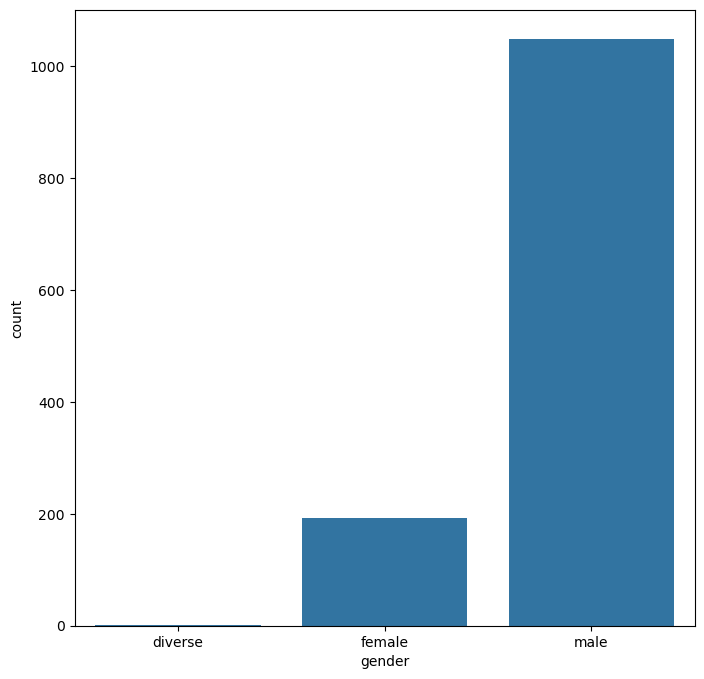

In [97]:
# Check distribution

sns.countplot(df, x=column);

print(f'Value counts: {df[column].value_counts()}')

##### **Observations**
- males dominate the data
- 'diverse' has too few values for a predictive model to learn from 
    - dropping only 'diverse' values creates some ethical concerns...
    - using gender would probably create more accurate predictions, but might be better off excluding it in the name of fairness
    - drop the column

### **'City'**
- **Inconsistencies:**
    - Countries/regions/etc rather than cities
    - Special characters ex. "()"
    - Invalid answers and extra text ("Prefer not to say", "area", "City in"
    - Abreviations
    - Spelling errors
    - Multiple spellings
- **Actions taken:**
    - Replace inconsistent values using mapping dictionary

In [98]:
# Basic EDA

column = 'city'
tb.eda_column_summary(df, column)

=== COLUMN: city ===

DTYPE:
category

NON-NULL VALUES:
1,253

NULL VALUES:
0

UNIQUE VALUES:
106

BASIC STATS:
count       1253
unique       106
top       berlin
freq         681
Name: city, dtype: object

TOP VALUES:
city
berlin       681
munich       236
frankfurt     44
hamburg       40
stuttgart     33
Name: count, dtype: int64

BOTTOM VALUES:
city
tampere (finland)    1
warsaw, poland       1
walldorf             1
wroclaw              1
wurzburg             1
Name: count, dtype: int64


In [ ]:
# Import world cities & countries from SimpleMaps

world = pd.read_csv('data/worldcities.csv')   
world = world[['city_ascii', 'country']]

world['city'] = world['city_ascii'].apply(tb.clean_string)
world['country'] = world['country'].apply(tb.clean_string)


In [102]:
# Compare world cities to df

df['is_valid_city'] = df[column].isin(world['city'])
city_no_match_df = df[df['is_valid_city']==False]
city_no_match_list = city_no_match_df[column].unique().tolist()
city_no_match_df[column].value_counts()

city
nurnberg            4
boeblingen          3
saint-petersburg    2
dusseldurf          1
bolingen            1
                   ..
warsaw              0
wolfsburg           0
wroclaw             0
wurzburg            0
zurich              0
Name: count, Length: 106, dtype: int64

In [103]:
# Count of unique City values before replacements

city_len_before = len(df[column].unique())
city_len_before

106

In [104]:
# Convert dtype to string

df[column] = df[column].astype("string")

In [105]:
# Replace invalid categories and values that are not cities

df[column] = df[column].replace({

    # Not a city, replace with largest city in region or country
    'france': 'paris',              
    'fr': 'paris',                 
    'city in russia': 'moscow',     
    'schleswig-holstein': 'kiel',     # german state
    'konstanz area': 'konstanz',    # region
    'bodensee': 'konstanz',         # lake    
    'nj, usa': 'newark',          
    'prefer not to say': None,
    'moldova': 'chisinau',          

    # Cities with extra text     
    'riga, latvia': 'riga',
    'tampere (finland)': 'tampere',
    'warsaw, poland': 'warsaw',

    # Misspellings or alternate spellings
    'boeblingen': 'boblingen',      # SimpleMaps uses 'Boblingen' (ASCII)
    'bolingen': 'boblingen',
    'nurnberg': 'nuremberg',
    'koln': 'cologne',
    'kiev': 'kyiv',
    'den haag': 'the hague',
    'cracovia': 'krakow',
    'cracow': 'krakow',
    'luttich': 'liege',
    'milano': 'milan',
    'dusseldurf': 'dusseldorf',
    'duesseldorf': 'dusseldorf',
    'saint-petersburg': 'saint petersburg'
})

In [108]:
# Compare world cities to df again

df['is_valid_city'] = df[column].isin(world['city'])
city_no_match_df = df[df['is_valid_city']==False]
city_no_match_list = city_no_match_df[column].unique().tolist()
city_no_match_df[column].value_counts()

Series([], Name: count, dtype: int64)

In [111]:
# Compare count of unique City values before and after replacements

city_len_after = len(df[column].unique())

print(f'# of unique values before replacements: {city_len_before}')
print(f'# of unique values after replacements: {city_len_after}')
print(f'Categories removed: {city_len_before-city_len_after}')

# of unique values before replacements: 106
# of unique values after replacements: 91
Categories removed: 15


In [112]:
# Convert dtype back to category

df[column] = df[column].astype("category")
df[column].info()

<class 'pandas.core.series.Series'>
RangeIndex: 1253 entries, 0 to 1252
Series name: city
Non-Null Count  Dtype   
--------------  -----   
1252 non-null   category
dtypes: category(1)
memory usage: 4.1 KB


In [ ]:
# Add Country feature to df

#CAUTION: MULTIPLE COUNTRIES PER CITY IS CREATING SOME MAPPING ISSUES...

#df = df.merge(
#    world[['city', 'country']], 
#    on='city', 
#    how='left'
#)

##### **Observations**
- invalid entries
    - non cities ex. 'France' and 'Fr' - replace with largest city in area
    - placeholder text ex. 'Prefer not to say' - replace with null
    - added text ex. 'tampere (finland)'  - replace with city only
    - misspelled cities - replace with correct spelling
    - city listed with multiple spellings - select a spelling and replace alternative
- consider adding column for country


### 'Position'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Position')

=== COLUMN: Position ===

DTYPE:
string

NON-NULL VALUES:
1,247

NULL VALUES:
6

BASIC STATS:
count                  1247
unique                  133
top       software engineer
freq                    387
Name: Position, dtype: object

TOP VALUES:
Position
software engineer     387
backend developer     174
data scientist        110
frontend developer     89
qa engineer            71
Name: count, dtype: Int64

BOTTOM VALUES:
Position
software architekt                       1
testmanager                              1
erp consultant                           1
researcher/ consumer insights analyst    1
it operations manager                    1
Name: count, dtype: Int64


###  'Total years of experience'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Total years of experience')

###  'Years of experience in Germany'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Years of experience in Germany')

=== COLUMN: Years of experience in Germany ===

DTYPE:
float64

NON-NULL VALUES:
1,195

NULL VALUES:
58

BASIC STATS:
count    1195.000000
mean        3.754812
std         3.656636
min         0.000000
25%         1.000000
50%         3.000000
75%         5.000000
max        30.000000
Name: Years of experience in Germany, dtype: float64

TOP VALUES:
Years of experience in Germany
2.0    195
1.0    189
3.0    155
5.0    142
4.0    122
Name: count, dtype: int64

BOTTOM VALUES:
Years of experience in Germany
26.0    1
4.5     1
0.1     1
2.6     1
0.2     1
Name: count, dtype: int64


###  'Seniority level'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Seniority level')

=== COLUMN: Seniority level ===

DTYPE:
string

NON-NULL VALUES:
1,241

NULL VALUES:
12

BASIC STATS:
count       1241
unique        21
top       senior
freq         565
Name: Seniority level, dtype: object

TOP VALUES:
Seniority level
senior    565
middle    366
lead      166
junior     79
head       44
Name: count, dtype: Int64

BOTTOM VALUES:
Seniority level
no idea, there are no ranges in the firm    1
c-level                                     1
working student                             1
entry level                                 1
self employed                               1
Name: count, dtype: Int64


###  'Your main technology / programming language'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Your main technology / programming language')

=== COLUMN: Your main technology / programming language ===

DTYPE:
string

NON-NULL VALUES:
1,125

NULL VALUES:
128

BASIC STATS:
count       1125
unique       206
top       python
freq         212
Name: Your main technology / programming language, dtype: object

TOP VALUES:
Your main technology / programming language
python        212
java          196
javascript     80
php            71
c++            41
Name: count, dtype: Int64

BOTTOM VALUES:
Your main technology / programming language
.net, c++, spss, embeddded    1
.net, angular                 1
atlassian jira                1
qlik                          1
consumer analysis             1
Name: count, dtype: Int64


###  'Other technologies/programming languages you use often'
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Other technologies/programming languages you use often')

=== COLUMN: Other technologies/programming languages you use often ===

DTYPE:
string

NON-NULL VALUES:
1,096

NULL VALUES:
157

BASIC STATS:
count                        1096
unique                        561
top       javascript / typescript
freq                           44
Name: Other technologies/programming languages you use often, dtype: object

TOP VALUES:
Other technologies/programming languages you use often
javascript / typescript    44
python                     37
sql                        31
aws, docker                16
kotlin                     15
Name: count, dtype: Int64

BOTTOM VALUES:
Other technologies/programming languages you use often
python, kotlin, ruby, aws, docker                               1
c/c++, .net, go                                                 1
c/c++, .net                                                     1
python, c/c++, rust, aws, kubernetes, docker                    1
python, c/c++, javascript / typescript, sql, go, aws, docker    1
N

###  'Yearly brutto salary (without bonus and stocks) in EUR'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

- consider dropping ind #1181

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Yearly brutto salary (without bonus and stocks) in EUR')

=== COLUMN: Yearly brutto salary (without bonus and stocks) in EUR ===

DTYPE:
float64

NON-NULL VALUES:
1,253

NULL VALUES:
0

BASIC STATS:
count    1.253000e+03
mean     8.027904e+07
std      2.825061e+09
min      1.000100e+04
25%      5.880000e+04
50%      7.000000e+04
75%      8.000000e+04
max      1.000000e+11
Name: Yearly brutto salary (without bonus and stocks) in EUR, dtype: float64

TOP VALUES:
Yearly brutto salary (without bonus and stocks) in EUR
60000.0    85
70000.0    83
65000.0    77
75000.0    73
80000.0    66
Name: count, dtype: int64

BOTTOM VALUES:
Yearly brutto salary (without bonus and stocks) in EUR
68250.0     1
84700.0     1
50500.0     1
108500.0    1
38350.0     1
Name: count, dtype: int64


###  'Yearly bonus + stocks in EUR'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Yearly bonus + stocks in EUR')

=== COLUMN: Yearly bonus + stocks in EUR ===

DTYPE:
float64

NON-NULL VALUES:
823

NULL VALUES:
430

BASIC STATS:
count    8.230000e+02
mean     6.096870e+06
std      1.742883e+08
min      0.000000e+00
25%      0.000000e+00
50%      5.000000e+03
75%      2.000000e+04
max      5.000000e+09
Name: Yearly bonus + stocks in EUR, dtype: float64

TOP VALUES:
Yearly bonus + stocks in EUR
0.0        227
5000.0      56
10000.0     45
2000.0      36
6000.0      26
Name: count, dtype: int64

BOTTOM VALUES:
Yearly bonus + stocks in EUR
110000.0    1
700.0       1
16320.0     1
105000.0    1
40950.0     1
Name: count, dtype: int64


###  'Number of vacation days'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Number of vacation days')

=== COLUMN: Number of vacation days ===

DTYPE:
float64

NON-NULL VALUES:
1,172

NULL VALUES:
81

BASIC STATS:
count    1172.000000
mean       28.348549
std        10.759972
min         0.000000
25%        27.000000
50%        28.000000
75%        30.000000
max       365.000000
Name: Number of vacation days, dtype: float64

TOP VALUES:
Number of vacation days
30.0    488
28.0    233
27.0    102
25.0     91
26.0     71
Name: count, dtype: int64

BOTTOM VALUES:
Number of vacation days
5.0     1
37.0    1
39.0    1
34.0    1
10.0    1
Name: count, dtype: int64


###  'Employment status'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Employment status')

=== COLUMN: Employment status ===

DTYPE:
string

NON-NULL VALUES:
1,236

NULL VALUES:
17

BASIC STATS:
count                   1236
unique                    10
top       full-time employee
freq                    1190
Name: Employment status, dtype: object

TOP VALUES:
Employment status
full-time employee            1190
self-employed (freelancer)      28
part-time employee               8
founder                          3
working student                  2
Name: count, dtype: Int64

BOTTOM VALUES:
Employment status
company director                                                                   1
full-time position, part-time position, & self-employed (freelancing, tutoring)    1
intern                                                                             1
full-time, but 32 hours per week (it was my request, i'm a student)                1
werkstudent                                                                        1
Name: count, dtype: Int64


###  'Сontract duration'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Сontract duration')

KeyError: 'Сontract duration'

###  'Main language at work'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Main language at work')

=== COLUMN: Main language at work ===

DTYPE:
string

NON-NULL VALUES:
1,237

NULL VALUES:
16

BASIC STATS:
count        1237
unique         14
top       english
freq         1020
Name: Main language at work, dtype: object

TOP VALUES:
Main language at work
english    1020
german      186
russian      12
italian       3
spanish       3
Name: count, dtype: Int64

BOTTOM VALUES:
Main language at work
50/50               1
deuglisch           1
french              1
both                1
russian, english    1
Name: count, dtype: Int64


###  'Company size'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
# Basic EDA

tb.eda_column_summary(df, 'Company size')

=== COLUMN: Company size ===

DTYPE:
string

NON-NULL VALUES:
1,235

NULL VALUES:
18

BASIC STATS:
count      1235
unique        5
top       1000+
freq        448
Name: Company size, dtype: object

TOP VALUES:
Company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     61
Name: count, dtype: Int64

BOTTOM VALUES:
Company size
1000+       448
101-1000    405
11-50       174
51-100      147
up to 10     61
Name: count, dtype: Int64


###  'Company type'
- **Definition:**
    - 
- **Inconsistencies:**
    -
- **Actions taken:**
    - 

In [ ]:
column = 'Company type'

In [ ]:
# Basic EDA

tb.eda_column_summary(df, column)

=== COLUMN: Company type ===

DTYPE:
string

NON-NULL VALUES:
1,228

NULL VALUES:
25

BASIC STATS:
count        1228
unique         57
top       product
freq          760
Name: Company type, dtype: object

TOP VALUES:
Company type
product                760
startup                252
consulting / agency    142
bank                     6
e-commerce               5
Name: count, dtype: Int64

BOTTOM VALUES:
Company type
industry        1
faang           1
old industry    1
outsourse       1
freelance       1
Name: count, dtype: Int64


In [ ]:
df[column].value_counts()

Company type
product                                                                     760
startup                                                                     252
consulting / agency                                                         142
bank                                                                          6
e-commerce                                                                    5
media                                                                         3
corporation                                                                   3
automotive                                                                    2
university                                                                    2
fintech                                                                       2
ecommerce                                                                     2
finance                                                                       2
utilities                  

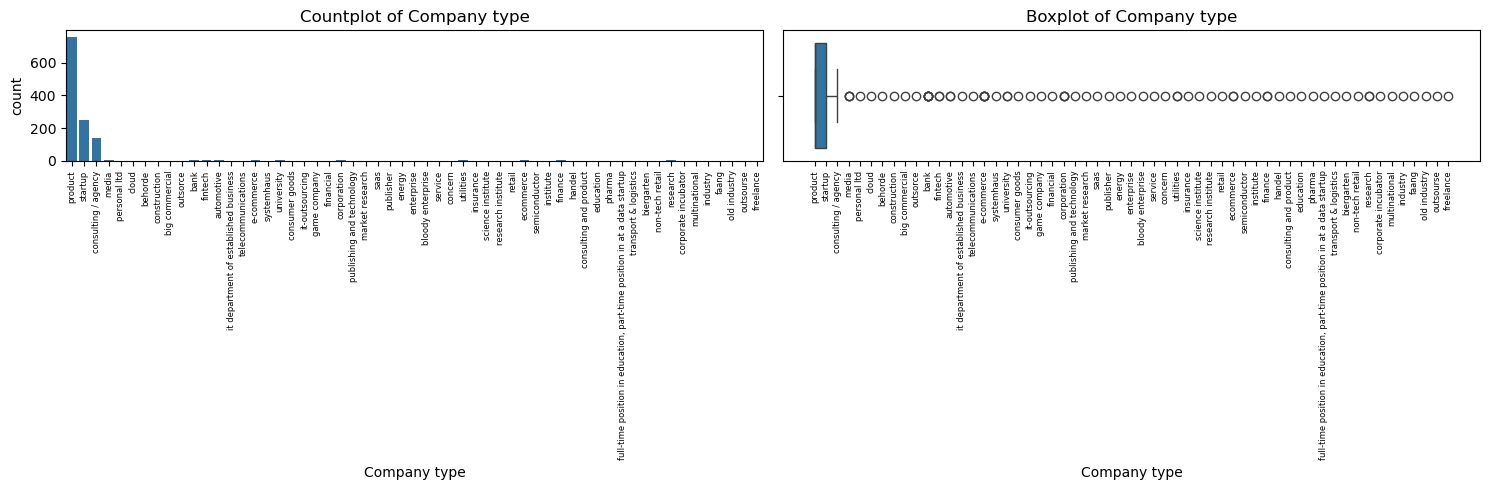

In [ ]:
tb.plot(df, columns=column)

# Answers and Explainations
(Expand/modify as needed)

### Here's the Data Cleaning Steps I Used

### Here's my Tuning/Feature Selection Steps

### Here's my Model's Performance

### Here's my Final Conclusion on What Worked Best